<h2 style='color:blue'>Small Image Classification Using Simple Aritifical Neural Network: GPU Benchmarking</h2>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
# Version Information
# tensorflow 2.2.0 , Cudnn7.6.5 and Cuda 10.1 , python 3.8

**This command shows list of physical devices available for tensorflow. You can see GPU listed here. If you have NVIDIA GPU you need to install CUDA toolkit and cuDNN as per instruction on this webpage. Without proper installation you will not see GPU in list of devices**

https://shawnhymel.com/1961/how-to-install-tensorflow-with-gpu-support-on-windows/

In [5]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [6]:
tf.__version__

'2.3.0'

In [7]:
tf.test.is_built_with_cuda()

True

<h4 style="color:purple">Load the dataset</h4>

Our dataset contains 60000 small training images that belongs to one of the below 10 classes

<img src="small_images.jpg" />

In [8]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [9]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
y_train.shape

(50000, 1)

<h4 style="color:purple">Data Visualization</h4>

In [8]:
def plot_sample(index):
    plt.figure(figsize = (10,1))
    plt.imshow(X_train[index])

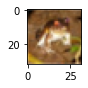

In [9]:
plot_sample(0)

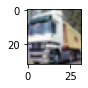

In [10]:
plot_sample(1)

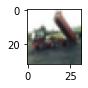

In [11]:
plot_sample(2)

In [12]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

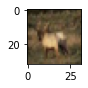

In [13]:
plot_sample(3)

In [14]:
classes[y_train[3][0]]

'deer'

In [15]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

In [16]:
y_test.shape

(10000, 1)

In [17]:
X_train.shape

(50000, 32, 32, 3)

<h4 style="color:purple">Preprocessing: Scale images</h4>

In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [12]:
y_train_categorical = keras.utils.to_categorical(
    y_train, num_classes=10, dtype='float32'
)
y_test_categorical = keras.utils.to_categorical(
    y_test, num_classes=10, dtype='float32'
)

In [20]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [21]:
y_train_categorical[0:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_categorical))

In [19]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [20]:
strategy.num_replicas_in_sync

1

In [21]:
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_tf_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE)

<h4 style="color:purple">Model building and training</h4>

In [23]:
with strategy.scope():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32,3)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(10, activation='sigmoid')    
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_dataset, epochs=1)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
782/782 [==============================] - 20s 26ms/step - loss: 1.9170 - accuracy: 0.3119


<h4 style="color:purple">Let's make some predictions</h4>

In [23]:
np.argmax(model.predict(X_test_scaled)[0])

1

In [24]:
y_test[0]

array([3], dtype=uint8)

In [25]:
def get_model():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32,3)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(10, activation='sigmoid')    
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

<h3 style='color:purple'>Measure training time on a CPU<h3>

In [26]:
%%timeit -n1 -r1 
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 22s 14ms/step - loss: 1.8604 - accuracy: 0.3347
23.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<h3 style='color:purple'>Lets measure training time on a GPU (I've NVIDIA Titan RTX)<h3>

In [27]:
%%timeit -n1 -r1 
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 22s 14ms/step - loss: 1.8649 - accuracy: 0.3332
22.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<h3 style='color:purple'>Lets run same test for 10 epocs<h3>

In [28]:
%%timeit -n1 -r1 
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8587 - accuracy: 0.3340
Epoch 2/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.6587 - accuracy: 0.4156
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5707 - accuracy: 0.4453
Epoch 4/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5084 - accuracy: 0.4698
Epoch 5/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.4557 - accuracy: 0.4880
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.4130 - accuracy: 0.5032
Epoch 7/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3747 - accuracy: 0.5150
Epoch 8/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3393 - accuracy: 0.5298
Epoch 9/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3084 - accuracy: 0.5382
Epoch 10/10
1563/1563 [==============================] - 23s 15m

In [29]:
%%timeit -n1 -r1 
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8697 - accuracy: 0.3276
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6632 - accuracy: 0.4105
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5717 - accuracy: 0.4443
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5094 - accuracy: 0.4672
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4596 - accuracy: 0.4855
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4153 - accuracy: 0.4992
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3792 - accuracy: 0.5153
Epoch 8/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3414 - accuracy: 0.5294
Epoch 9/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3096 - accuracy: 0.5386
Epoch 10/10
1563/1563 [==============================] - 22s 14m

Here is the performance comparison for 1 epoch,

| Epoch | CPU | GPU  |
|:------|:------|:------|
| 1 | 43 sec | 3 sec |
| 10 | 7 min 26 sec | 30 sec |

You can see that GPU is almost 15 times faster. We ran only one epoch for benchmarking but for actual training we have to run many epochs and also when data volume is big running deep learning without GPU can consume so much time. This is the reason why GPUs are becoming popular in the field of deep learning